# Clustering com BERTimbau e K-Means

Neste notebook, utilizaremos o modelo `BERTimbau` para extrair embeddings de textos e, em seguida, utilizaremos o algoritmo K-Means para agrupá-los. O BERTimbau é uma variação do BERT pré-treinada especialmente para o português.

## 1. Importando as bibliotecas

In [12]:
# Instalando dependências
%pip install transformers
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt

## 2. Carregando os dados

In [4]:
# Carregando os dados
df = pd.read_csv("./data/Leis de Sorocaba (Clean).csv")

# Preenchendo os valores nulos com uma string vazia:
df['summary'] = df['summary'].fillna('')

# Remover termos irrelevantes:
remove_phrases = ['dispor sobre', 'dar outro providência', 'dar outro providencia']
remove_phrases_regex = '|'.join(remove_phrases)
df['summary'] = df['summary'].str.replace(remove_phrases_regex, ' ', regex=True).str.strip()

## 3. Preparando o modelo BERTimbau

Carregaremos o tokenizador e o modelo BERTimbau para extrair os embeddings.


In [2]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

## 4. Função para Extração de Embeddings

Vamos definir uma função que irá nos ajudar a extrair embeddings do BERTimbau para nossos textos.

In [3]:
def extract_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Utilizaremos o CLS token (primeira posição) como a representação do texto
    return outputs['last_hidden_state'][0][0].numpy()

# Exemplo
sample_text = "Texto exemplo para testar a função."
print(extract_embedding(sample_text))

[ 1.48464024e-01 -1.24193549e-01  2.46683955e-01  3.58867645e-01
  3.53321046e-01  4.13656056e-01  1.23279579e-01 -2.49590874e-01
  5.38282216e-01  1.63538441e-01 -5.46482325e-01  1.04740240e-01
  3.18573005e-02  6.76924437e-02 -2.08662122e-01 -1.74124584e-01
  2.75954694e-01  5.94570994e-01 -1.88163668e-01  4.36159670e-01
 -1.55580211e-02  6.21876977e-02  3.46054763e-01 -2.64783889e-01
  3.33153963e-01  2.58598588e-02 -4.51849878e-01  6.18180156e-01
  2.03226000e-01 -1.85996354e-01 -7.99551755e-02  5.00557303e-01
  7.98312053e-02  9.76423249e-02 -3.07632163e-02  2.51734582e-05
  2.79439818e-02 -1.47154732e-02  2.11648252e-02 -3.38970721e-01
  2.78072078e-02 -2.99677432e-01 -3.94855738e-02 -2.87668586e-01
 -1.43817395e-01 -3.42119575e-01  7.74209425e-02  3.19493443e-01
 -4.12302285e-01 -2.12856978e-02 -8.61459300e-02 -2.42216848e-02
  8.02685693e-02  2.06480324e-01  5.35972714e-01  3.89860794e-02
  1.83174521e-01 -3.05602521e-01 -8.98975953e-02  1.28757372e-01
 -1.07870378e-01 -8.09565

## 5. Extração dos Embeddings

Vamos processar nossos dados e extrair os embeddings para cada texto.


In [5]:
df['embedding'] = df['summary'].apply(extract_embedding)


## 5. Agrupamento com K-Means

Agora, utilizaremos o algoritmo K-Means para agrupar os embeddings.

In [7]:
X = np.array(df['embedding'].tolist())
kmeans = KMeans(n_clusters=11, n_init=10)  # Aqui, estamos supondo 11 clusters, mas você pode escolher outro número
df['cluster'] = kmeans.fit_predict(X)


## 6. Análise dos Clusters

Finalmente, vamos analisar os clusters formados.


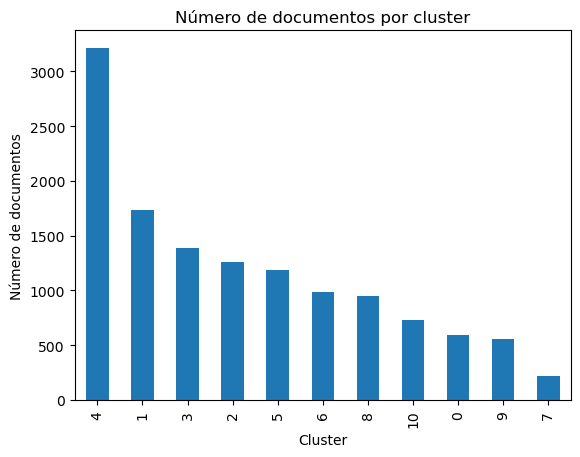

In [10]:
# Calculando o número de documentos por cluster
df['cluster'].value_counts().plot(kind='bar', title='Número de documentos por cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de documentos')
plt.show()

In [11]:
# Exibindo algumas amostras de textos por cluster
num_samples = 11  # você pode ajustar esse número conforme desejar

for cluster in df['cluster'].unique():
    print(f"\nCluster {cluster}:\n")
    samples = df[df['cluster'] == cluster]['summary'].sample(num_samples)
    for idx, sample in enumerate(samples, 1):
        print(f"{idx}. {sample}\n")



Cluster 3:

1. atitude respeito bandeira hino

2. código obra município

3. denominação Alberto grosso pem-so Nº 34 de este cidade

4. denominação fausto Ferreira Telles próprio público cidade

5. denominação trovador candini via público cidade

6. denominação gentil Francisco gebaile pontilhão cidade

7. denominação fausto Ferreira Telles praça público cidade

8. regulamento mercado municipal

9. denominação plácido Rodrigues Miranda praça público cidade

10. denominação professora darlene devasto próprio público cidade

11. alteração descrição rua Pedro Moreira césar


Cluster 4:

1. denominação laércio Rocha via público cidade

2. denominação José alípio Soares Filho via público cidade

3. denominação José Abel Buckart via público cidade

4. denominação drjurgen ulderup via público cidade

5. denominação Francisca Paula Jesus Izabel via público cidade

6. denominação Sueli Martins Madureira via público cidade

7. denominação Antônia Simão Rodrigues via público cidade

8. denominaçã

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def get_representative_docs_for_cluster(cluster_id, df, n_docs=5):
    # Filtrar embeddings pelo cluster
    cluster_embeddings = np.array(df[df['cluster'] == cluster_id]['embedding'].tolist())
    
    # Calcular o vetor médio do cluster
    centroid = cluster_embeddings.mean(axis=0)
    
    # Calcular a similaridade entre o centroide e todos os documentos no cluster
    similarities = cosine_similarity(cluster_embeddings, centroid.reshape(1, -1))
    
    # Pegar os n_docs documentos mais similares
    top_docs_indices = similarities.flatten().argsort()[-n_docs:][::-1]
    
    return df[df['cluster'] == cluster_id].iloc[top_docs_indices]

def get_top_terms_for_cluster(cluster_id, df, n_docs=5, n_terms=10):
    representative_docs = get_representative_docs_for_cluster(cluster_id, df, n_docs)
    
    # Tokenização e contagem de termos dos documentos representativos
    all_terms = []
    for doc in representative_docs['summary']:
        all_terms.extend(doc.split())  # supondo que os documentos já estejam tokenizados
    
    # Usando Counter para pegar os termos mais comuns
    from collections import Counter
    counter = Counter(all_terms)
    
    return [item[0] for item in counter.most_common(n_terms)]

In [28]:
# Exemplo de uso:
cluster_id = 4  # Exemplo de cluster
print(get_top_terms_for_cluster(cluster_id, df, n_docs=150, n_terms=10))

['via', 'público', 'cidade', 'denominação', 'José', 'João', 'Antonio', 'Oliveira', 'Carlos', 'Antônio']
